<a href="https://colab.research.google.com/github/DimitrisLianos/DL/blob/main/DCGAN_%E2%80%94_Implementing_Deep_Convolutional_Generative_Adversarial_Network_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from IPython import display

import torch
from torch import nn
from torch.autograd.variable import Variable
import torch.optim as optim
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
import torchvision.utils
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils


from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Mount Google Drive
drive.mount('/content/drive')

# Authenticate and create PyDrive client
gauth = GoogleAuth()
gauth.credentials = GoogleDrive(gauth)
drive_client = GoogleDrive(gauth)

# Path to the dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data_DCGAN_Implementing_Deep_Convolutional_Generative_Adversarial_Network_in_TensorFlow/train_anime_data.rar"

# Unzip the dataset
!unrar x "{dataset_path}" "/content/dataset/"

def load_images(directory='', size=(64, 64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)

    return images

# Load the images
image_dir = '/content/dataset/train_anime_data'
images = load_images(image_dir)

Epoch 3/3: 100%|█████████▉| 21504/21551 [02:50<00:00, 126.06image/s, D_loss=0.532, G_loss=4.08]


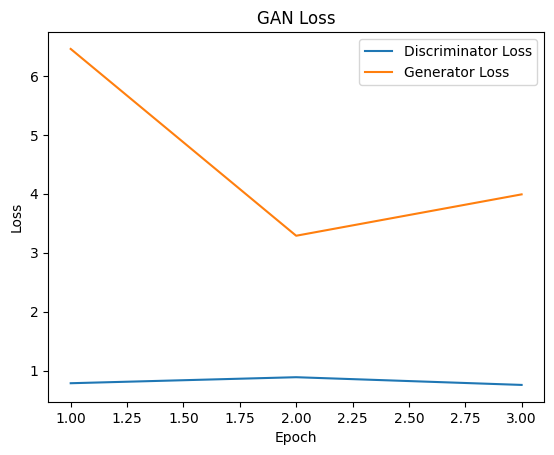

In [14]:


# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim, img_channels, hidden_dim):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, hidden_dim * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels, hidden_dim):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(img_channels, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(hidden_dim * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Initialize hyperparameters
num_epochs = 3
batch_size = 128
noise_dim = 100
img_channels = 3
hidden_dim = 64

# Create the generator and discriminator models
generator = Generator(noise_dim, img_channels, hidden_dim)
discriminator = Discriminator(img_channels, hidden_dim)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Define the loss function
adversarial_loss = nn.BCELoss()

# Create optimizers for generator and discriminator
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load the images
image_dir = '/content/dataset/train_anime_data'
train_images = load_images(image_dir)

# Check the number of channels in the input images
num_channels = train_images[0].shape[-1]
if num_channels != 3:
    raise ValueError("Input images should have 3 channels (RGB).")

# Setup the optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
d_loss_history = []
g_loss_history = []

for epoch in range(num_epochs):
    # Create a progress bar
    progress_bar = tqdm(total=len(train_images), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="image")

    # Initialize epoch losses
    d_losses = []
    g_losses = []

    for i in range(0, len(train_images) - batch_size + 1, batch_size):
        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake images
        fake_images = generator(noise)

        # Real images
        real_images = torch.tensor(train_images[i:i + batch_size], dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Labels for the discriminator
        real_labels = torch.ones((batch_size, 1, 1, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1, 1, 1), device=device)

        # Reset discriminator gradients
        discriminator.zero_grad()

        # Discriminator loss on real images
        real_output = discriminator(real_images)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # Discriminator loss on fake images
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_discriminator.step()

        ### Train Generator ###
        generator.zero_grad()

        # Generate new fake images
        fake_images = generator(noise)

        # Compute generator loss
        outputs = discriminator(fake_images)
        g_loss = adversarial_loss(outputs, real_labels)

        # Update the generator
        g_loss.backward()
        optimizer_generator.step()

        # Update the progress bar
        progress_bar.update(batch_size)
        progress_bar.set_postfix({"D_loss": d_loss.item(), "G_loss": g_loss.item()})

        # Append current losses to epoch losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Handle the remaining images (if the total number of images is not divisible by the batch size)
    if len(train_images) % batch_size != 0:
        remaining_images = len(train_images) % batch_size

        # Generate random noise for the remaining images
        noise = torch.randn(remaining_images, noise_dim, 1, 1, device=device)

        # Generate fake images
        fake_images = generator(noise)

        # Real images
        real_images = torch.tensor(train_images[-remaining_images:], dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Labels for the discriminator
        real_labels = torch.ones((remaining_images, 1, 1, 1), device=device)
        fake_labels = torch.zeros((remaining_images, 1, 1, 1), device=device)

        # Reset discriminator gradients
        discriminator.zero_grad()

        # Discriminator loss on real images
        real_output = discriminator(real_images)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # Discriminator loss on fake images
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_discriminator.step()

        ### Train Generator ###
        generator.zero_grad()

        # Generate new fake images
        fake_images = generator(noise)

        # Compute generator loss
        outputs = discriminator(fake_images)
        g_loss = adversarial_loss(outputs, real_labels)

        # Update the generator
        g_loss.backward()
        optimizer_generator.step()

        # Append current losses to epoch losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Compute average loss values
    d_loss_avg = np.mean(d_losses)
    g_loss_avg = np.mean(g_losses)

    d_loss_history.append(d_loss_avg)
    g_loss_history.append(g_loss_avg)

    # Close the progress bar for the epoch
    progress_bar.close()

    # Generate and save sample images
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(25, noise_dim, 1, 1).to(device)
            sample_images = generator(sample_noise).cpu()

            # Rescale images from [-1, 1] to [0, 1]
            sample_images = (sample_images + 1) / 2

            # Create a grid of sample images
            grid = torchvision.utils.make_grid(sample_images, nrow=5, normalize=True)

            # Save the grid image
            torchvision.utils.save_image(grid, f"generated_images_epoch_{epoch + 1}.png")

# Save the generator and discriminator models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

# Plot the GAN loss curve
plt.figure()
plt.plot(range(1, num_epochs + 1), d_loss_history, label='Discriminator Loss')
plt.plot(range(1, num_epochs + 1), g_loss_history, label='Generator Loss')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
